In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from ema import read

df = read.ax6_summary()
df

,residents_id,accel_date,n_valid_all,avg_inact_mins_all,avg_light_mins_all,avg_mod_mins_all,avg_vig_mins_all,avg_mvpa_mins_all,avg_wake_mins_all,avg_sleep_mins_all,...,zbmi,bmicat,zbmi_change,organised_PA,ph_9_mean,paq_score,PE_related_PA,school_recreational_PA,outside_school_PA,weekend_PA
0,40.0,2022-04-24,4.0,731.687988,228.395996,28.542000,2.000,30.542,990.625000,449.375000,...,0.266155,Healthy weight,0.535745,1.173913,1.857143,2.447895,quite often,1.5,3.5,4.0
1,41.0,2022-04-24,5.0,691.732971,282.450012,35.382999,1.283,36.666,1010.849976,429.149994,...,1.003298,Overweight,-0.117251,1.217391,2.142857,2.151139,I dont do PE,1.5,2.5,4.0
2,42.0,2022-04-24,4.0,958.583008,216.979004,26.958000,0.833,27.791,1203.354004,236.645996,...,-1.037208,Underweight,-2.153997,1.739130,3.000000,1.748792,I dont do PE,1.0,2.0,2.0
3,46.0,2022-04-21,3.0,892.250000,194.722000,21.833000,0.250,22.083,1109.056030,330.944000,...,0.057294,Healthy weight,-0.311795,1.086957,1.857143,1.660455,I dont do PE,1.5,2.0,3.0
4,110.0,2022-04-18,1.0,853.416992,142.667007,23.500000,0.500,24.000,1020.083008,419.916992,...,2.790148,Obese,-0.754868,1.608696,2.857143,1.718426,quite often,1.5,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,39814.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.196305,Obese,0.580453,1.347826,2.142857,1.832298,I dont do PE,1.0,2.0,3.0
622,39829.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.547819,Overweight,0.289909,1.043478,1.000000,1.115942,I dont do PE,1.0,1.0,1.0
623,39830.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.504402,Obese,0.243121,1.434783,2.000000,2.603865,quite often,2.0,3.0,4.0
624,39831.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.509202,Healthy weight,0.518500,1.000000,1.000000,1.222222,sometimes,1.0,1.0,1.0


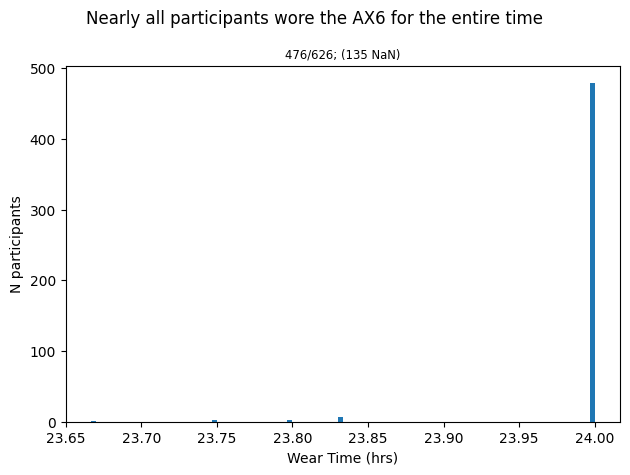

In [3]:
import numpy as np
import matplotlib.pyplot as plt

img_dir = "img/ax6"
if not os.path.isdir(img_dir):
    os.mkdir(img_dir)

col = "avg_wtime_mins_all"

fig, axis = plt.subplots()

weartime_hrs = df[col] / 60
axis.hist(weartime_hrs, bins=100)

axis.set_xlabel("Wear Time (hrs)")
axis.set_ylabel("N participants")

fig.suptitle("Nearly all participants wore the AX6 for the entire time")
axis.set_title(
    f"{(weartime_hrs == 24).sum()}/{len(df)}; ({weartime_hrs.isna().sum()} NaN)",
    fontsize="small",
)

fig.tight_layout()

fig.savefig(f"{img_dir}/ax6_wear_time_hist.png")

In [4]:
"""
Create a classifier to predict final BMI from the AX6 summary data

"""
from sklearn.model_selection import train_test_split

prediction_cols = [
    "avg_inact_mins_all",
    "avg_light_mins_all",
    "avg_mvpa_mins_all",
    "int_gradient_all",
    "avg_sleep_mins_all",
    "bmi_2018",
]
target = "bmical"
clf_df = df.copy()[prediction_cols + [target]]

clf_df = clf_df.dropna()

X, y = clf_df[prediction_cols], clf_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [5]:
"""
Train the classifier
"""
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


clf = RandomForestRegressor(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)


RandomForestRegressor(random_state=0)

In [6]:
"""
Compare train + test predictions
"""
y_pred = clf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # or mse**(0.5)
r2 = r2_score(y_test, y_pred)

print("Test:")
print("\tRMSE:", rmse)
print("\tR2:", r2)

y_pred_train = clf.predict(X_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_pred_train)

print("Train:")
print("\tRMSE:", rmse)
print("\tR2:", r2)

Test:
	RMSE: 3.288218792498578
	R2: 0.7082793833368037
Train:
	RMSE: 1.1158577531510752
	R2: 0.9544817007384716


In [7]:
"""
Compare to a baseline model - always the mean

"""
y_baseline = np.full(y_test.shape, y_train.mean())

# Compute metrics for the baseline
mse_baseline = mean_squared_error(y_test, y_baseline)
rmse_baseline = np.sqrt(mse_baseline)
r2_baseline = r2_score(y_test, y_baseline)

print("Baseline RMSE:", rmse_baseline)
print("Baseline R2:", r2_baseline)

Baseline RMSE: 6.2719855
Baseline R2: -0.0613430988095367


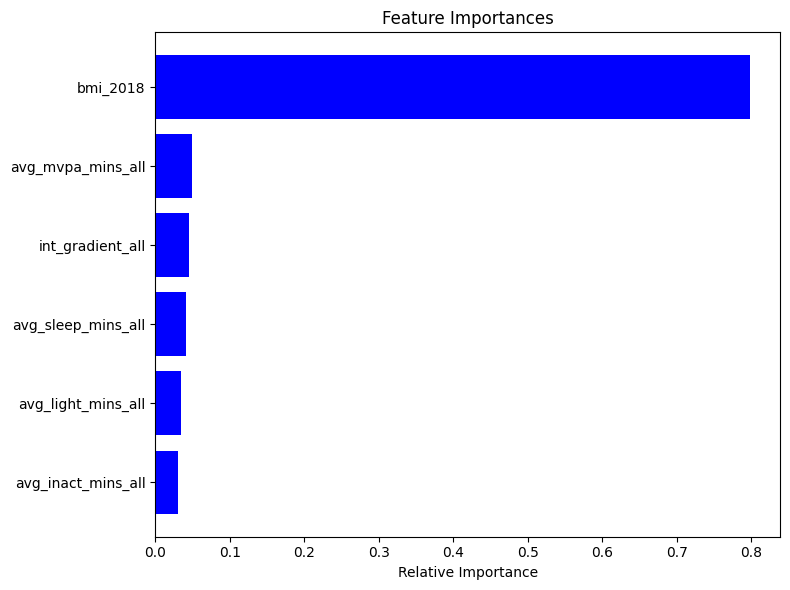

In [8]:
"""Plot feature importances"""
importances = clf.feature_importances_
indices = np.argsort(importances)

fig, axis = plt.subplots(figsize=(8, 6))
axis.set_title("Feature Importances")

axis.barh(range(len(indices)), importances[indices], color="b", align="center")

axis.set_yticks(range(len(indices)), [prediction_cols[i] for i in indices])
axis.set_xlabel("Relative Importance")
fig.tight_layout()

fig.savefig(f"{img_dir}/ax6_feature_importances.png")

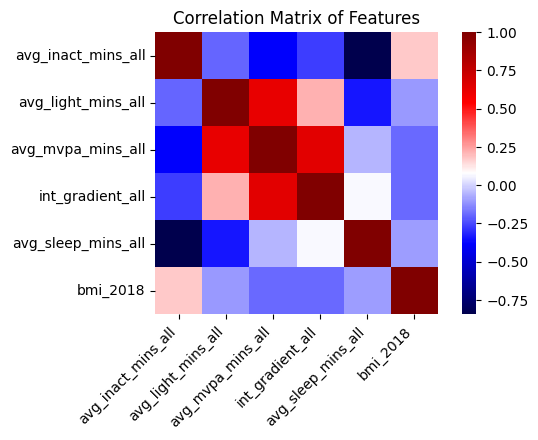

In [9]:
"""
Plot features' correlation matrix

"""
import seaborn as sns

fig, axis = plt.subplots()

# Assuming df is your DataFrame
corr_matrix = clf_df[prediction_cols].corr()

sns.heatmap(
    corr_matrix, fmt=".2f", ax=axis, cmap="seismic", cbar=True, square=True
)
axis.set_title("Correlation Matrix of Features")

fig.tight_layout()
plt.xticks(rotation=45, ha="right")

fig.savefig(f"{img_dir}/ax6_feature_correlation_matrix.png")

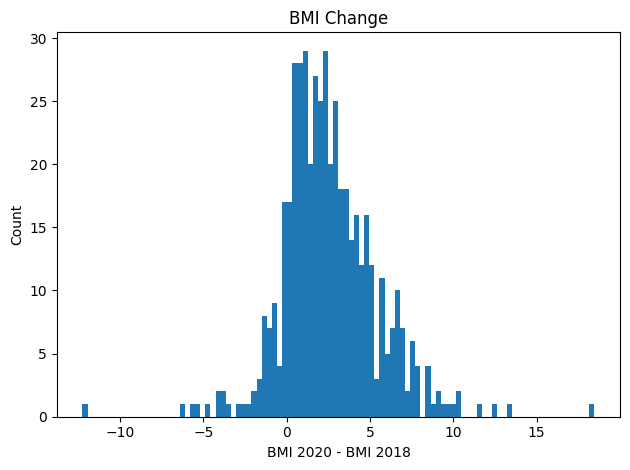

In [10]:
"""
Let's do the same thing to predict BMI change

"""
clf_df["bmi_change"] = clf_df["bmical"] - clf_df["bmi_2018"]

fig, axis = plt.subplots()
axis.hist(clf_df["bmi_change"], bins=100)
axis.set_xlabel("BMI 2020 - BMI 2018")
axis.set_ylabel("Count")

axis.set_title("BMI Change")
fig.tight_layout()

fig.savefig(f"{img_dir}/bmi_change_hist.png")

In [11]:
"""
Remove starting BMI from the prediction columns

"""
prediction_cols = [c for c in prediction_cols if c != "bmi_2018"]

X, y = clf_df[prediction_cols], clf_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [12]:
y_baseline = np.full(y_test.shape, y_train.mean())

# Compute metrics for the baseline
mse_baseline = mean_squared_error(y_test, y_baseline)
rmse_baseline = np.sqrt(mse_baseline)
r2_baseline = r2_score(y_test, y_baseline)

print("Baseline RMSE:", rmse_baseline)
print("Baseline R2:", r2_baseline)

Baseline RMSE: 6.2719855
Baseline R2: -0.0613430988095367


In [63]:
clf = RandomForestRegressor(n_estimators=50, random_state=0, max_depth=None)
clf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50, random_state=0)

In [64]:
y_pred = clf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Test:")
print("\tRMSE:", rmse)
print("\tR2:", r2)

y_pred_train = clf.predict(X_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_pred_train)

print("Train:")
print("\tRMSE:", rmse)
print("\tR2:", r2)

Test:
	RMSE: 6.450602757943862
	R2: -0.1226549735438145
Train:
	RMSE: 2.201687833628321
	R2: 0.8227934211244363


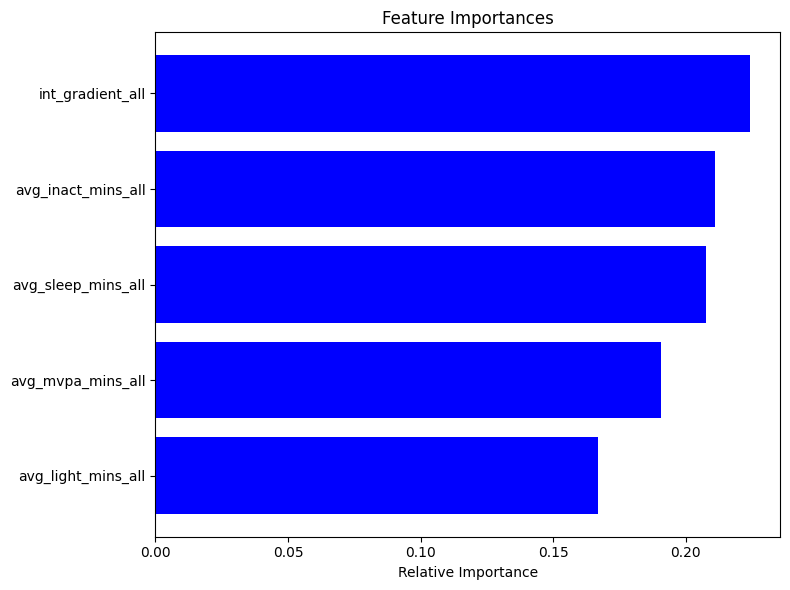

In [65]:
naive_importances = clf.feature_importances_
indices = np.argsort(naive_importances)

fig, axis = plt.subplots(figsize=(8, 6))
axis.set_title("Feature Importances")

axis.barh(range(len(indices)), naive_importances[indices], color="b", align="center")

axis.set_yticks(range(len(indices)), [prediction_cols[i] for i in indices])
axis.set_xlabel("Relative Importance")
fig.tight_layout()

fig.savefig(f"{img_dir}/bmi_change_naive_importance.png")

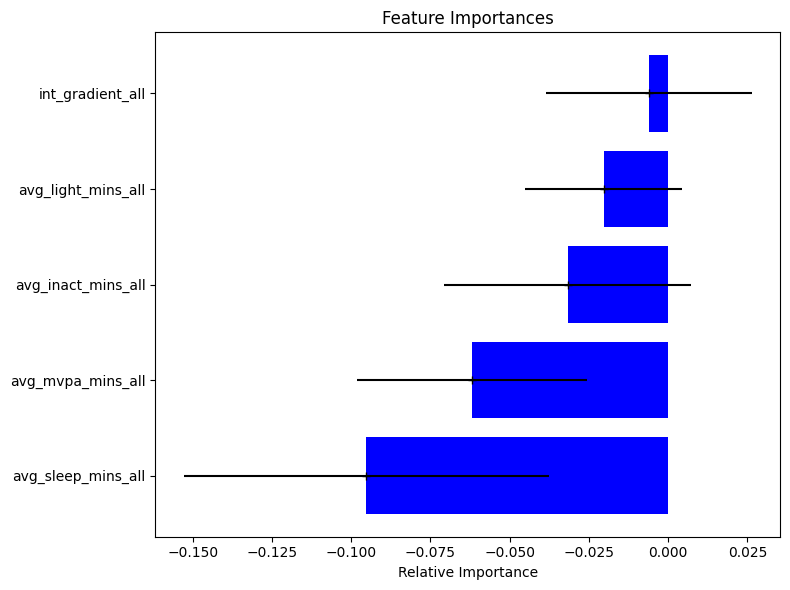

In [66]:
"""
Remake with permutation importance

"""
from sklearn.inspection import permutation_importance

perm = permutation_importance(clf, X_test, y_test)
perm_importance = perm.importances_mean
perm_errs = perm.importances_std

indices = np.argsort(perm_importance)

fig, axis = plt.subplots(figsize=(8, 6))
axis.set_title("Feature Importances")

axis.barh(range(len(indices)), perm_importance[indices], color="b", align="center")
axis.errorbar(
    perm_importance[indices], range(len(indices)), xerr=perm_errs[indices], fmt="k+"
)

axis.set_yticks(range(len(indices)), [prediction_cols[i] for i in indices])
axis.set_xlabel("Relative Importance")
fig.tight_layout()

fig.savefig(f"{img_dir}/bmi_change_perm_importance.png")